In [2]:
import pandas as pd
import pubchempy as pcp

water_miscibility_df = pd.read_csv("water_miscibility_table.csv")
aqueous_solubility_df = pd.read_csv("Aqueous_Solubility.csv")[["Solubility Prediction", "Molecule_InChIKey"]]
aqueous_solubility_df.rename(columns={"Molecule_InChIKey": "Solvent_InChIKey"}, inplace=True)

def fun_to_apply(row):
    solvent_name = row["Solvent"]
    compounds = pcp.get_compounds(solvent_name, 'name')
    return compounds[0].inchikey

water_miscibility_df["Solvent_InChIKey"] = water_miscibility_df.apply(fun_to_apply, axis=1)

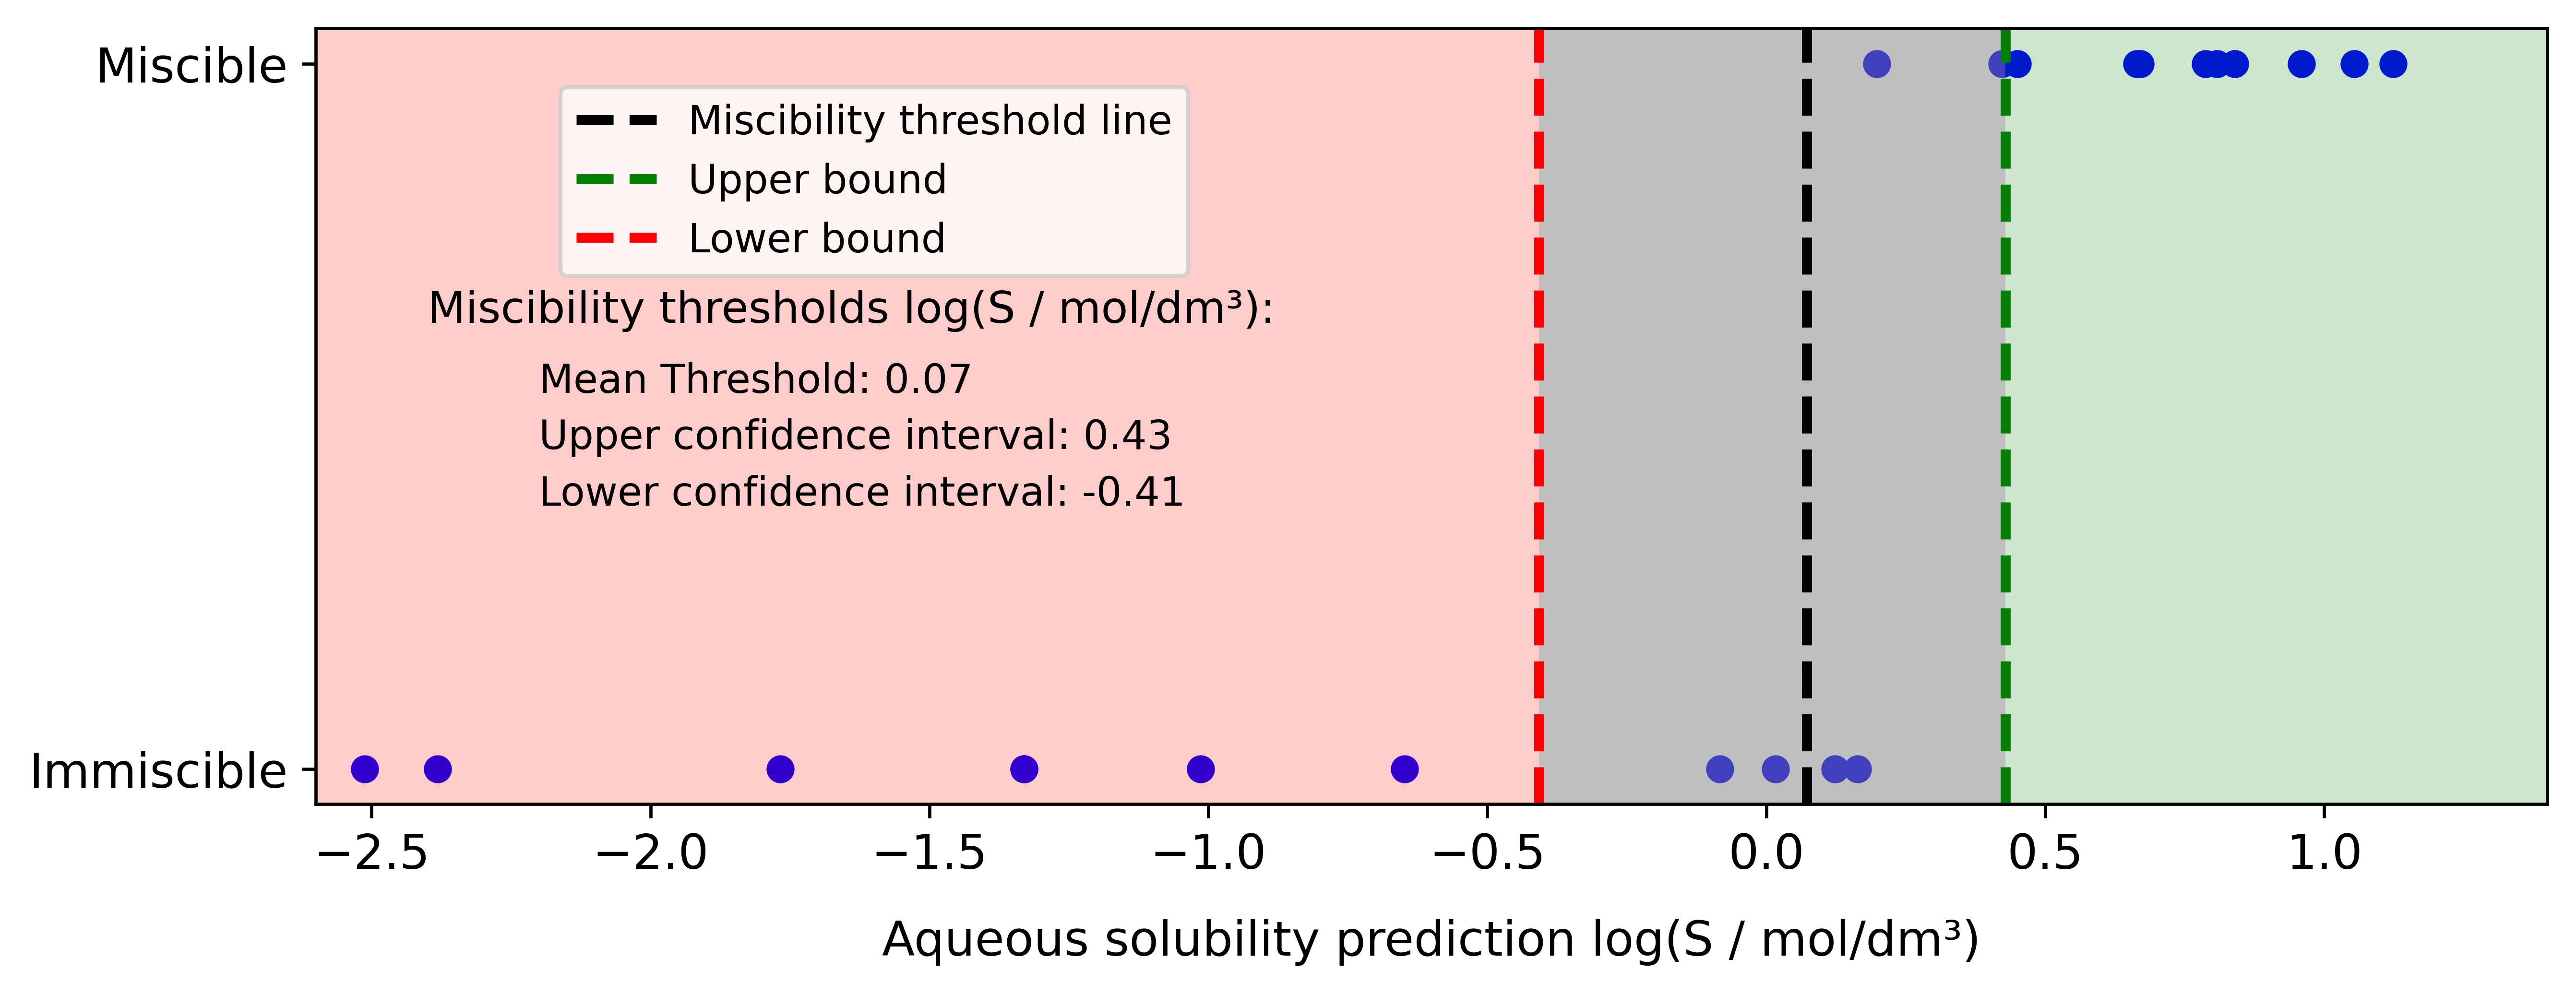

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.utils import resample

# Getting the dataframes and x_data/y_data
final_dataframe = pd.merge(water_miscibility_df, aqueous_solubility_df, how='inner', on='Solvent_InChIKey')
final_dataframe.to_csv("Miscibility and solubility predictions.csv")
final_dataframe['Miscible with Water'] = final_dataframe['Miscible with Water'].map({True: 1, False: 0}) #Just changing it to numbers
x_data = final_dataframe[['Solubility Prediction']]  
y_data = final_dataframe['Miscible with Water']  

# Threshold determination with bootstrapping:
n_bootstrap = 5000 #This is definitely more than enough
bootstrap_thresholds = []

for i in range(n_bootstrap):
    
    x_resampled, y_resampled = resample(x_data, y_data, replace=True)
    
    # Training the model
    model = SVC(kernel='linear', probability=True, random_state=1)
    model.fit(x_resampled, y_resampled)
    
    # The threshold is just the intercept divided by the coefficient 
    threshold_x = -model.intercept_[0] / model.coef_[0][0]
    bootstrap_thresholds.append(threshold_x)


# Now the final threshold will simply be the mean of all the calculated thresholds
mean_threshold = np.mean(bootstrap_thresholds)

# Most importantly the confidence interval will be calculated:
confidence_interval_lower = np.percentile(bootstrap_thresholds, 5.0)
confidence_interval_upper = np.percentile(bootstrap_thresholds, 95.0)

# Making the plot
plt.figure(figsize=(10, 3.5), dpi=600)
plt.scatter(final_dataframe['Solubility Prediction'], final_dataframe['Miscible with Water'], color='blue')
plt.axvline(mean_threshold, color='black', linestyle='--', linewidth=2.5, label=f'Miscibility threshold line')
plt.axvline(confidence_interval_upper, color='green', linestyle='--', linewidth=2.5, label='Upper bound')
plt.axvline(confidence_interval_lower, color='red', linestyle='--', linewidth=2.5, label='Lower bound')
plt.axvspan(xmin=min(list(final_dataframe['Solubility Prediction']))-2,
           xmax=confidence_interval_lower, facecolor='red', alpha=0.2)
plt.axvspan(xmin=confidence_interval_lower, xmax=confidence_interval_upper, facecolor='grey', alpha=0.5)
plt.axvspan(xmin=confidence_interval_upper, xmax=max(list(final_dataframe['Solubility Prediction']))+2,
           facecolor='green', alpha=0.2)
plt.xlim(left=-2.6)
plt.xlim(right=1.4)
plt.locator_params(axis='x', nbins=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Aqueous solubility prediction log(S / mol/dm³)', fontsize=12, labelpad=10)
plt.text(-2.4, 0.65, f'Miscibility thresholds log(S / mol/dm³):', fontsize=11, verticalalignment='center', horizontalalignment='left')
plt.text(-2.2, 0.55, f'Mean Threshold: {mean_threshold:.2f}', fontsize=10, verticalalignment='center', horizontalalignment='left')
plt.text(-2.2, 0.47, f'Upper confidence interval: {confidence_interval_upper:.2f}', fontsize=10, verticalalignment='center', horizontalalignment='left')
plt.text(-2.2, 0.39, f'Lower confidence interval: {confidence_interval_lower:.2f}', fontsize=10, verticalalignment='center', horizontalalignment='left')
plt.yticks([0, 1], ['Immiscible', 'Miscible'])
plt.legend(bbox_to_anchor=(0.40, 0.95))

plt.savefig("Miscibility Threshold Determination.png")

In [5]:
from sklearn.metrics import accuracy_score

# Classify based on the mean threshold
y_pred = (x_data['Solubility Prediction'] >= mean_threshold).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_data, y_pred)

print(f"Classification Accuracy: {accuracy:.2f}")

Classification Accuracy: 0.92


In [6]:
def fun_to_apply(row):
    solubility = row["Solubility Prediction"]
    if solubility > -0.41 and solubility < 0.43:
        return True
    else:
        False

final_dataframe["Grey Line"] = final_dataframe.apply(fun_to_apply, axis=1)
final_dataframe = final_dataframe[final_dataframe["Grey Line"] == True]
final_dataframe

,Solvent,Miscible with Water,Solvent_InChIKey,Solubility Prediction,Grey Line
2,Acetonitrile,1,WEVYAHXRMPXWCK-UHFFFAOYSA-N,0.422817,True
4,Butanol,0,LRHPLDYGYMQRHN-UHFFFAOYSA-N,0.123703,True
11,Diethyl Ether,0,RTZKZFJDLAIYFH-UHFFFAOYSA-N,-0.083016,True
13,Dimethyl Sulfoxide,1,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,0.198138,True
16,Ethyl Acetate,0,XEKOWRVHYACXOJ-UHFFFAOYSA-N,0.017032,True
21,Methyl Ethyl Ketone,0,ZWEHNKRNPOVVGH-UHFFFAOYSA-N,0.163961,True


In [7]:
final_dataframe["Solvent"]

2            Acetonitrile
4                 Butanol
11          Diethyl Ether
13     Dimethyl Sulfoxide
16          Ethyl Acetate
21    Methyl Ethyl Ketone
Name: Solvent, dtype: object